# Getting started with Keras

## CSCI E-82A
## Stephen Elston

## Overview

This notebook will provides a first look at using the Keras package to define, train and evaluate deep learning models with Keras. By the end of this lesson you will be able to work with basic feedforward architecture multi-layer neural nets. Feedforward networks are one of a class of basic models called **sequential models** which are easy to define with Keras. Further, some basic regularization is introduced. Additional regularization methods are covered in a subsequent lesson. 


### 1.1 Installing Keras

Keras has recently become part of Tensorflow. Therefore the most straight-forward way to install Keras is by installing Tensorflow first. You can find [installation instructions for Keras](https://keras.io/) for Tensorflow, CNTK and Theano on the Keras web site. Carefully read the limitations and possible pitfalls for you operating system which ever framework you choose. 


****
**Note:** This notebook was constructed and tested using Anaconda 3 with Python 3. It is assumed that the standard Anaconda stack has been installed.
****

### 1.2 Keras architecture

Keras is a wrapper over other deep learning frameworks. Keras provides consistent and simplified APIs for using these underlying frameworks. In this lesson we will focus on the widely used Python API. 

### 1.3 Overview of Keras documentation

One of the many nice features of Keras is complete and useful documentation. Complete documentation including installation instructions can be found on the [Keras website](https://keras.io/#keras-the-python-deep-learning-library). As you learn to work with Keras, you will want to refer to the well-indexed documentation and examples on this site. 

A the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by François Chollet, the creator of Keras, provides in-depth examples and discussion on a wide range of deep learning applications. 

## 2.0 A first feed-forward Keras example

Without further adu, let's try an example. We will build a simple feedforward neural network to classify handwriten digits from the famious MNIST data set. MNIST contains 60,000 labeled training images and 10,000 test images. To many people MNIST is the 'hello world' problem of deep learning. 

### 2.1 Loading the MNIST data set

MNIST is built intoo the `keras.datasets` package. We only need to import this package and then load it. 

The first step is to import the packages we will need for the rest of this notebook. Execute the code in the cell below to load these packages. This code should eecute without errors or warnings if everything is installed correctly. 

In [1]:
from keras.datasets import mnist
import keras.utils.np_utils as ku
import keras.models as models
import keras.layers as layers
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Notice that the TensorFlow backend has been loaded along with various Keras packages. Keras is making calls to TensorFlow to perform compuations.

Now, load the training and testing images and corresponding labels by executing the coded in the cell below. . 

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

With the data loaded, let's have a peak at some of the content. The images of the handwritten digits are represented as rectangular arrays of dimension $$28x28$. You can see this by executing the code in the cell below.

In [3]:
print(train_images[4].shape)

(28, 28)


The handwritten images are all gray-scale, so do not have a color dimension. 

The code in the cell below displays 4 of the 60,000 images of handwritten digits along with their labels. Execute this code and examine the results.  

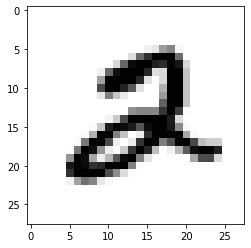

Label = 2


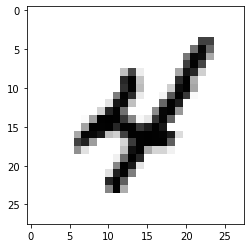

Label = 4


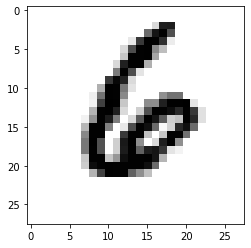

Label = 6


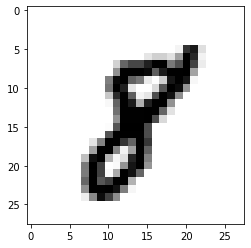

Label = 8


In [4]:
for i in range(5, 20, 4):
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.show()
    print('Label = ' + str(train_labels[i]))

### 2.2 Prepare the data for training.

As is the case with all machine learning problems, preparing the data is an important step. Without careful data preparation even the best models will produce poor results, or even fail to execute. 

The MNIST images are stored as a 3-d tensor. For the training data this tensor has dimensions $60000\ x\ 28\ x\ 28$. However, to traning a neural network on these images we must flatten this representation so that each image is a vector of length $28 * 28$. The result will be a 2-d tensor of dimensions $60000\ x\ (28*28)$.

Further, models created with Keras, and most other deep learning frameworks, operate on floating point numbers. The gray scale pixel values of the images are coded as integers in the range $\{ 0, 255 \}$. These pixel values must be coerced to floating point and then standardized to be in a range $\{ 0.0, 1.0 \}$. As is the case for training many machine learning models, it is best to use standardized values for training deep neural networks. 

The code in the cell below flattens the images and converts the pixel values to a standardized floating point number. Execute this code.

In [5]:
print(train_images.shape, train_labels.shape)
train_images = train_images.reshape((60000, 28*28)).astype('float32')/255
print(train_images.shape)
print(train_images.dtype)

(60000, 28, 28) (60000,)
(60000, 784)
float32


Notice the original shape and resulting shape of the training image tensor. In addition, the array is now of type `float32`. 

Execute the code in the cell below to apply the  same transformation to the test images. 

In [6]:
print(test_images.shape, test_labels.shape)
test_images = test_images.reshape((10000, 28*28)).astype('float32')/255
print(test_images.shape)

(10000, 28, 28) (10000,)
(10000, 784)


Since we are working on a classification problem, the label values must be of a categrocial type. Execute the code in the cell below and examine the coding of  these labels. 

In [7]:
print(train_labels[5:,])

[2 1 3 ... 5 6 8]


The labels are coded as integers corresponding to the digit in the image. These values must be coerced to a categorical type. Fortunately the `to_categorical` method in the `keras.utils.np_utils` package does just this. Execute the code in the cell below and examine the printed results. 

In [8]:
train_labels = ku.to_categorical(train_labels)
print(train_labels[5:,])

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Notice that the label values have been converted from integers to a set of 10 dummy variables. The columns of the dummy variables represent digits in the range $\{ 0,9 \}$. One dummy variable per case will be coded as $1$ and the rest coded as $0$. For example the first row in the example above encodes a $2$, and the second row encodes a $1$.

Execute the code in the cell below to coerce the test labels to dummy variables. 

In [9]:
test_labels = ku.to_categorical(test_labels)

### 2.3  Defining a sequential model

The data is prepared, so it is time to start defining a neural nework model. We are using a simple feedforward model which is one type of sequential model Keras can create. There is a general receipe for defining sequential Keras models:

1. Define a sequential model object.
2. Define one or more hidden layers.
3. Define an output layer. 

You will find a [quick start guide to Keras sequential models](https://keras.io/getting-started/sequential-model-guide/) in the Keras documentation 

Speficially in this case, the squential model is defined as follows:
1. A sequential model object `nn` is defined. 
2. A single hidden layer is defined. 
  - This layer is dense (fully connected) with 512 units. 
  - The activation of each unit is rectilinear.
  - The hidden layer is expecting an input tensor of $28*28$ by an undefined number of cases (images). 
3. The output layer has 10 hidden units. 
  - We need 10 units since there are 10 categories of handwritten digits we are classifing. 
  - This is a **Multinomial** classification problem so we are using softmax activation. 
  
Execute this code to define the model. 

In [10]:
nn = models.Sequential()
nn.add(layers.Dense(512, activation = 'relu', input_shape = (28*28, )))
nn.add(layers.Dense(10, activation = 'softmax'))

W1117 15:39:37.700664  7144 deprecation_wrapper.py:119] From C:\Users\StevePC2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1117 15:39:37.784919  7144 deprecation_wrapper.py:119] From C:\Users\StevePC2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1117 15:39:37.811845  7144 deprecation_wrapper.py:119] From C:\Users\StevePC2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



### 2.4 Training and evaluating the sequential model

With a defined model it is time to train and evaluate it. First, the model must be compiled by executing the code below. This call sepecifies the following:

1. Specify an optimizer. We will discuss optimizers in a subsequent lesson. 
2. Specify a loss function. In this case we are performing Multinomial classification so we are using `categorical_crossentropy`.
3. Specify one or more metrics used to evaluate the performance of the model. In this case we are using just one metric, accuracy. 

In [11]:
nn.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

W1117 15:39:37.911576  7144 deprecation_wrapper.py:119] From C:\Users\StevePC2\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1117 15:39:38.010862  7144 deprecation_wrapper.py:119] From C:\Users\StevePC2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



Now, the model is ready to be trained using the `fit` method by executing the code in the cell below. The `fit` method has several arguments:

1. The training features.
2. The training labels.
3. The number of epochs (iterations) over which the model is trained.
4. The batch size used for the optimizer. The meaning of this will be discussed in the lesson on optimizaton. 

In [12]:
nn.fit(train_images, train_labels, epochs = 5, batch_size = 128)

W1117 15:39:38.299184  7144 deprecation.py:323] From C:\Users\StevePC2\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1117 15:39:38.521016  7144 deprecation_wrapper.py:119] From C:\Users\StevePC2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/5
60000/60000 [==============================] - 10s 159us/step - loss: 0.2593 - acc: 0.9247
Epoch 2/5
60000/60000 [==============================] - 7s 116us/step - loss: 0.1040 - acc: 0.9689
Epoch 3/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.0681 - acc: 0.9790 1s - loss: 0.0697 - acc: 0.9 - ETA: 1s - loss: 0.0694 - acc: 0.978 - ETA: 1s - loss: 0.0694 - acc: 0.97 - ETA: 1s - loss: 0.0695 - - ETA: 1s - loss: 0.0697 - ac - ETA: 1s - loss: 0.0699 - acc: 0.97 - ETA: 1s - loss: 0.0698 - ac - ETA: 0s - loss: 0.069 - ETA: 0s - loss: 0.0682 - ac - ETA: 0s - loss: 0.0678 - acc: 0
Epoch 4/5
60000/60000 [==============================] - 10s 170us/step - loss: 0.0501 - acc: 0.984511s - loss: 0.04 - ETA: 9s - loss: 0.0422 - - ETA: 10s - loss: 0.0437 - ac - ETA: 9s - loss: 0.0463 - acc: 0.98 - ETA: 9s - loss: 0.0468 - acc: 0.9 - ETA: 9s - loss: 0.0472 - acc: - ETA: 9s - loss: 0.0470 - acc: 0.9 - ETA: 9s - loss:   - ETA: 5s - loss - ETA: 3s - l - ETA: 1s - loss

Notice that the loss declines and the accuracy increases with each training epoch. However, since neural networks tend to be overfit, these improved figures may or may not indicate that the model is actually getting better. Keep in mind that the model may simply be learning the training data. 

It is necessary to test the model on independent data set. The `evaluate` method allows you to do just this. Execute the code in the cell below and compair the results to training results.  

In [13]:
nn.evaluate(test_images, test_labels)

10000/10000 [==============================] - ETA:  - 1s 69us/step


[0.06766461960775778, 0.9795]

It is clear that the model is over-fit since the evaluation loss and accuracy are quite a bit worse than observed in training. 

## 3.0 Training over epochs

In order to determine at what point a model is overfit during training it is necessary to evaluate the model after each training epoch. 

The `test_model` function in the cell below iterates the `train` function over increasing numbers of epochs for the model defined. A list of evaluation metrics is created and printed at the end. The test function fits the model for the specified number of epochs and evaluates the result.  

If you wish to execute this code uncomment the call in the last line of the cell and run the code. Expect execution to take a while. 

In [14]:
nnt = models.Sequential()
nnt.add(layers.Dense(512, activation = 'relu', input_shape = (28*28, )))
nnt.add(layers.Dense(10, activation = 'softmax'))
nnt.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
    
history = nnt.fit(train_images, train_labels, 
                  epochs = 10, batch_size = 128,
                  validation_data = (test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.2586 - acc: 0.9245 - val_loss: 0.1254 - val_acc: 0.9622
Epoch 2/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.1038 - acc: 0.9691 - val_loss: 0.0886 - val_acc: 0.9731
Epoch 3/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.0688 - acc: 0.9793 - val_loss: 0.0739 - val_acc: 0.9769
Epoch 4/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.0498 - acc: 0.9849 - val_loss: 0.0688 - val_acc: 0.9784
Epoch 5/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0372 - acc: 0.9889 - val_loss: 0.0693 - val_acc: 0.9783
Epoch 6/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.0290 - acc: 0.9913 - val_loss: 0.0699 - val_acc: 0.9804
Epoch 7/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.0222 - acc: 0.9933 - val_loss: 0.0688 - val_

To aid in understanding these figures it will help to make some plots comparing the training and evaluation performance as the training epochs evolve. The code in the next two cells does this is a somewhat primitive manner. The Numpy array is manually edited to include the training loss and training accuracy. 

The `plot_loss` and `plot_performance` functions in the next two cell plot the training loss or accuracy in blue and the test loss or accuracy in red. Execute the code and examine the plots. 

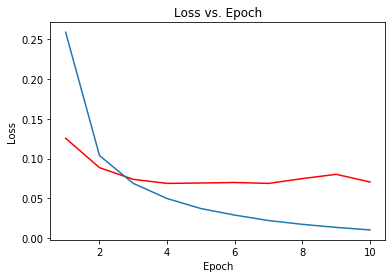

In [15]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red')
    plt.plot(x, train_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    
plot_loss(history)  

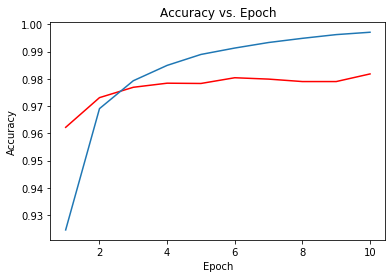

In [16]:
def plot_accuracy(history):
    train_acc = history.history['acc']
    test_acc = history.history['val_acc']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red')
    plt.plot(x, train_acc)  
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')  
    
plot_accuracy(history)    

Notice that the training loss and accuracy continue to improve throughout the epochs. However, the evaluation loss and accuracy only improve significantly for the first four, or perhaps 5, epochs. This is clear evidence that subsequent epochs are simply over-fitting the model. 

## 4.0 Adding hidden layers

Next, we will add an additional hidden layer to the model. Addiional layers add capacity to the model to represent complex function. However, the network becomes more susceptible to over fitting. 

The code in the cell below defines a model similar to the first one, but with a second layer defined. Notice that the definition of the two layer model is nearly the same as for the single layer model. In this case, the second layer has the same number of units and activation function as the first. 

However, notice that the `input_shape` does not need to be defined for hidden layers past the first. Keras will determine the dimensions of tensors passed between layers past the input. 

If you wish to execute this code uncomment the call in the last line of the cell and run the code. Expect execution to take a while. 

In [17]:
nnt = models.Sequential()
nnt.add(layers.Dense(512, activation = 'relu', input_shape = (28*28, )))
nnt.add(layers.Dense(512, activation = 'relu'))
nnt.add(layers.Dense(10, activation = 'softmax'))
nnt.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
    
    
history = nnt.fit(train_images, train_labels, 
                  epochs = 10, batch_size = 128,
                  validation_data = (test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.2212 - acc: 0.9326 - val_loss: 0.0989 - val_acc: 0.9680 ETA: 8s - lo
Epoch 2/10
60000/60000 [==============================] - 4s 74us/step - loss: 0.0817 - acc: 0.9748 - val_loss: 0.0786 - val_acc: 0.9744
Epoch 3/10
60000/60000 [==============================] - 9s 146us/step - loss: 0.0538 - acc: 0.9831 - val_loss: 0.0876 - val_acc: 0.9752
Epoch 4/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.0383 - acc: 0.9878 - val_loss: 0.0718 - val_acc: 0.9813
Epoch 5/10
60000/60000 [==============================] - 9s 145us/step - loss: 0.0292 - acc: 0.9911 - val_loss: 0.0859 - val_acc: 0.9794
Epoch 6/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.0223 - acc: 0.9930 - val_loss: 0.0785 - val_acc: 0.9801
Epoch 7/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.0188 - acc: 0.9943 - val_loss

As before, we can best understand these results by creating plots of the loss and accuracy for training and evaluation vs. epoch. Execute the code in the two cells below to display these plots and study the results. 

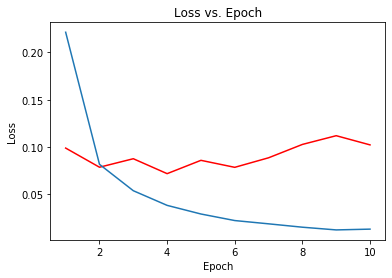

In [18]:
plot_loss(history)  

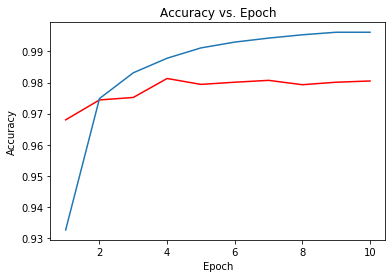

In [19]:
plot_accuracy(history)    

Notice that after epoch four the true (training) loss actually increases, whereas the training loss continues to decrease. This is a clear indication of overfitting. 

When compared to the single layer example, the over-fitting is more obvious. This should not be a suprise, since the number of weights has nearly doubled from the single layer model. 

## 5.0 Adding regularization to the model

Regularization is used to prevent over-fitting of machine learning models including neural networks. The Keras `regularizers` package provides L1 and L2 regularizaiton methods. The theory of regularization will be addressed in other lessons. In addition you can find [documentation on the Keras `regularizers` package](https://keras.io/regularizers/).  

The code in the cell below adds the `kernel_regularizer` argument with the value of `regularizers.l2(0.01)` This adds a weight decay penalty of 0.01 to the model weights. 

If you wish to execute this code uncomment the call in the last line of the cell and run the code. Expect execution to take a while. 

In [20]:
nnt = models.Sequential()
nnt.add(layers.Dense(512, activation = 'relu', input_shape = (28*28, ),
                        kernel_regularizer=regularizers.l2(0.01)))#
nnt.add(layers.Dense(10, activation = 'softmax'))
nnt.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    
history = nnt.fit(train_images, train_labels, 
                  epochs = 10, batch_size = 128,
                  validation_data = (test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.9164 - acc: 0.8890 - val_loss: 0.4531 - val_acc: 0.9121
Epoch 2/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.4245 - acc: 0.9212 - val_loss: 0.3639 - val_acc: 0.9387
Epoch 3/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.3822 - acc: 0.9302 - val_loss: 0.3868 - val_acc: 0.9227
Epoch 4/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.3586 - acc: 0.9349 - val_loss: 0.3545 - val_acc: 0.9348
Epoch 5/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.3418 - acc: 0.9391 - val_loss: 0.3232 - val_acc: 0.9442
Epoch 6/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.3257 - acc: 0.9421 - val_loss: 0.3195 - val_acc: 0.9439
Epoch 7/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.3157 - acc: 0.9446 - val_loss: 0.2754 - v

Once again, we can best understand these results by creating plots of the loss and accuracy for training and evaluation vs. epoch. Execute the code in the two cells below to display these plots and study the results. 

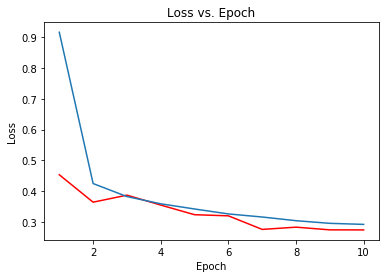

In [21]:
plot_loss(history)  

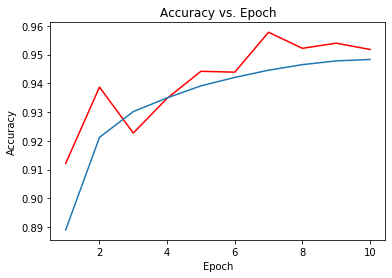

In [22]:
plot_accuracy(history)    

Compare these results to the pervious two models. 

First, notice that the loss values are significantly higher and the accuracy lower. This is to 

In [23]:
nnt.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


#### Copyright 2018, Stephen F Elston. All rights reserved. 